# Notebook for Protein Predict
Please first set the dir paths before running

In [1]:
import numpy as np

import scanpy as sc
import torch
import warnings
import pandas as pd
import torch
from torch_geometric.loader import DataLoader
from Model.dgat import GATEncoder, Decoder_Protein, Decoder_mRNA
from utils.Preprocessing import qc_control_cytassist, normalize, clean_protein_names, fill_genes, preprocess_ST
from Model.Train_test import train_and_evaluate_fold, protein_predict,get_activity

import random
import os

from utils.idk_utils import leiden_plot, find_edges_LN,leiden_plot_scatter

warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

dataset_save_dir = '/ix/hosmanbeyoglu/haw309/DGAT_Datasets'

pyg_save_dir = '/ix/hosmanbeyoglu/haw309/pyg_data' # Building a graph might take 5 mins or more (depends on the scale of the dataset).This directory is used to save the graph data in PyG format, which can be reused for prediction without rebuilding the graph.
model_save_dir = '/ix/hosmanbeyoglu/haw309/DGAT_models'# Directory to save the trained DGAT model. If you have a pre-trained model , please set this to the directory where the model is saved. 
pred_result_path = '/ix/hosmanbeyoglu/haw309/DGAT_results' # Not necessary to set this directory, but if you want to save the prediction results, please set this to the directory where you want to save the results and uncomment the last line of each section.

hidden_dim=1024
dropout_rate=0.3

seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/ihome/crc/install/pytorch/2.0.1/python3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load common genes and proteins for prediction

In [2]:
with open("common_gene_11535.txt", "r") as f: 
    common_gene = [line.strip() for line in f]

with open("common_protein_31.txt", "r") as f: 
    common_protein = [line.strip() for line in f]

## Prediction requires an existing DGAT model, which can be trained using the `Demo_Train.ipynb` notebook. Please set the `model_save_dir` to the directory where the trained model is saved. Or you may use the pre-trained model provided here: `TBD`. 

Before the prediction, we need to preprocess the data, including: QC, normalization, and gene filling (for those samples that lost some genes during the training). The `preprocess_ST` and `fill_genes` function will perform these steps.

### Lymph Node

In [3]:
import tarfile
if not hasattr(tarfile, 'data_filter'):
    tarfile.data_filter = None 

import scanpy as sc
adata_LN = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_LN.var_names_make_unique()
celltypes = pd.read_csv("W_cell_density.csv", index_col=0)
gc_annotation = pd.read_csv("manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)
obs_names = np.intersect1d(celltypes.index, adata_LN.obs_names)
adata_LN = adata_LN[obs_names]
celltypes = celltypes.loc[obs_names]
gc_annotation = gc_annotation.loc[obs_names]
adata_LN.obsm['celltype'] = celltypes
adata_LN.obsm['celltype'].columns = [x.replace('mean_spot_factors','') for x in adata_LN.obsm['celltype'].columns]
adata_LN.obsm['celltype_raw'] = adata_LN.obsm['celltype'].copy()
adata_LN.obsm['celltype'] = adata_LN.obsm['celltype'].divide(adata_LN.obsm['celltype'].sum(axis=1), axis=0)
adata_LN.obs['germinal_center'] = gc_annotation
adata_LN.obs['germinal_center'] = adata_LN.obs['germinal_center'].map({0: "Other", 1: "GC"})

preprocess_ST(adata_LN)
adata_LN = fill_genes(adata_LN, common_gene)


Sample lost 0 genes, 11535 in total


In [4]:
points, edges = find_edges_LN(adata_LN)

In [5]:
pdata_LN = protein_predict(adata_LN,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'V1_Human_Lymph_Node' from '/ix/hosmanbeyoglu/haw309/pyg_data/V1_Human_Lymph_Node_11535_spatial=6_testing.pth'
Dataset ready


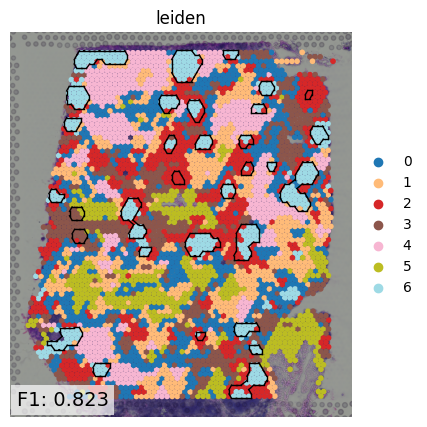

In [6]:
pdata_LN = leiden_plot(pdata_LN,n_neighbors = 10, points = points, edges = edges, plot_type = 'F1', resolution = 0.43,size = 1.7,title=f'Leiden Clustering by Predicted Protein from DGAT', palette = 'tab20',save_fig = False)


In [7]:
#pdata_LN.write(f'{pred_result_path}/LN.h5ad')

### TNBC

In [8]:
adata_Breast = sc.read_h5ad('/ix/hosmanbeyoglu/haw309/breast/CID44971.h5ad')


In [9]:
preprocess_ST(adata_Breast)
adata_Breast = fill_genes(adata_Breast, common_gene)

Sample lost 161 genes, 11535 in total


In [10]:
pdata_Breast = protein_predict(adata_Breast,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'CID44971' from '/ix/hosmanbeyoglu/haw309/pyg_data/CID44971_11535_spatial=6_testing.pth'
Dataset ready


AnnData object with n_obs × n_vars = 1127 × 31
    obs: 'in_tissue', 'array_row', 'array_col', 'subtype', 'pathology', 'sample', 'replicate', 'ER', 'HER2', 'PR', 'n_genes', 'leiden'
    uns: 'spatial', 'log1p', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'spatial'
    layers: 'protein_predict'
    obsp: 'distances', 'connectivities'


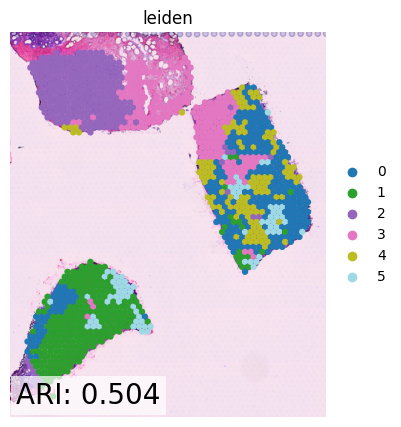

In [11]:
pdata_Breast = leiden_plot(pdata_Breast,n_neighbors = 10, plot_type = 'ARI', resolution = 0.45, true_label_key = 'pathology', size = 1.7,title=f'Leiden Clustering by Predicted Protein from DGAT', palette = 'tab20',save_fig = False)


In [12]:
#pdata_Breast.write(f'{pred_result_path}/CID44971_50.h5ad')

### Melanoma

In [13]:
import h5py
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
from anndata import AnnData

file_path = '/ix/hosmanbeyoglu/haw309/Melanoma_ST_DATA/Melanoma_filtered_feature_bc_matrix.h5'

with h5py.File(file_path, 'r') as f:
    X = csr_matrix(f["X"][:]) 
    cell_barcodes = f["obs"]["_index"][:].astype(str)
    gene_names = f["var"]["gene"][:].astype(str)
    if "spatial" in f["obsm"]:
        spatial_coords = f["obsm"]["spatial"][:]
    else:
        spatial_coords = None

adata_Melanoma = AnnData(
    X,
    obs=pd.DataFrame(index=cell_barcodes),
    var=pd.DataFrame(index=gene_names)
)

if spatial_coords is not None:
    adata_Melanoma.obsm["spatial"] = spatial_coords
adata_Melanoma.uns['name'] = 'Melanoma'

spatial_df = pd.read_csv('/ix/hosmanbeyoglu/haw309/Melanoma_ST_DATA/coordinates.csv', index_col=0)
if adata_Melanoma.shape[0] == spatial_df.shape[0]:
    adata_Melanoma.obsm["spatial"] = spatial_df.values

labels_csv_file = "/ix/hosmanbeyoglu/haw309/Melanoma_ST_DATA/manual_annotations_wo_unannotated_reg.csv"

labels_df = pd.read_csv(labels_csv_file, index_col=0)

adata_Melanoma.obs["label_ann"] = 3

common_indices = adata_Melanoma.obs.index.intersection(labels_df.index)
adata_Melanoma.obs.loc[common_indices, "label_ann"] = labels_df.loc[common_indices, "label_ann"]
cluster_mapping = {
        0: "Melanoma",
        1: "Lymphoid",
        2: "Stroma",
        3: "Unannotated"
    }
    
# Apply the mapping to the Leiden clusters
adata_Melanoma.obs["annotation"] = adata_Melanoma.obs["label_ann"].astype(int).map(cluster_mapping)

In [14]:
adata_Melanoma.var_names = [var.split(' ')[0] for var in adata_Melanoma.var_names]
adata_Melanoma.var_names_make_unique()
preprocess_ST(adata_Melanoma)
adata_Melanoma = fill_genes(adata_Melanoma, common_gene)

Sample lost 756 genes, 11535 in total


In [15]:
pdata_Melanoma = protein_predict(adata_Melanoma,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'Melanoma' from '/ix/hosmanbeyoglu/haw309/pyg_data/Melanoma_11535_spatial=6_testing.pth'
Dataset ready


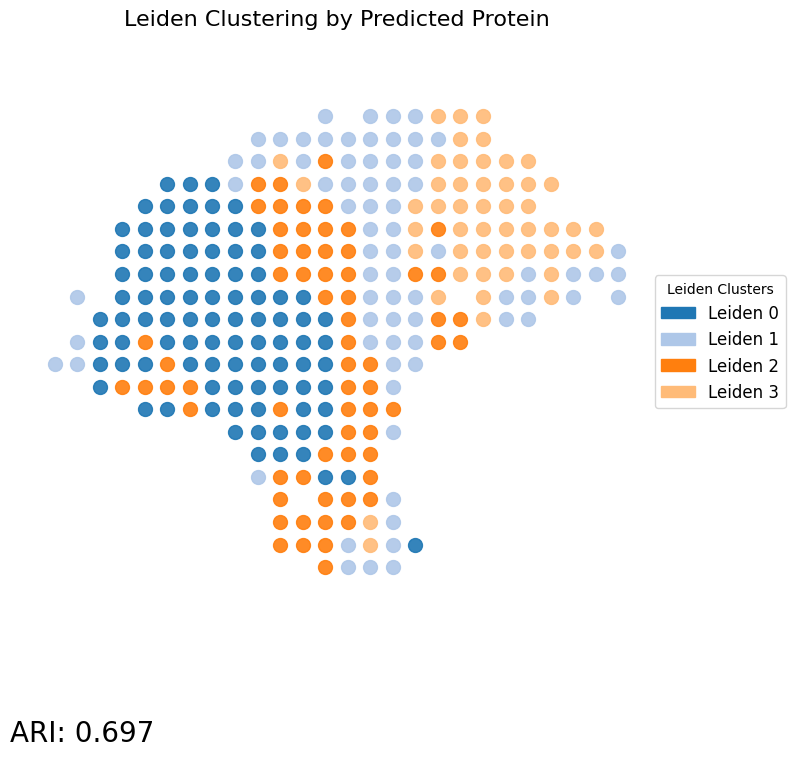

In [16]:
pdata_Melanoma = leiden_plot_scatter(pdata_Melanoma, n_neighbors=10, resolution=0.42, true_label_key = 'annotation', None_anno_cluster = 'Unannotated')

In [17]:
#pdata_Melanoma.write(f'{pred_result_path}/Melanoma.h5ad')

### Prostate

In [18]:
import pandas as pd
import numpy as np
from anndata import AnnData

cell_info = pd.read_csv('/ix/hosmanbeyoglu/haw309/iImpact_data/human prostate cancer FFPE data/10x_human_prostate_cancer_ffpe_manual_annotation.csv')
spot_loc = pd.read_csv('/ix/hosmanbeyoglu/haw309/iImpact_data/human prostate cancer FFPE data/10x_human_prostate_cancer_ffpe_loc.csv', index_col=0)
count     = pd.read_csv('/ix/hosmanbeyoglu/haw309/iImpact_data/human prostate cancer FFPE data/10x_human_prostate_cancer_ffpe_count.csv', index_col=0)

adata_Prostate = AnnData(X=count.values)
adata_Prostate.obs_names = count.index.astype(str)
adata_Prostate.var_names = count.columns


spot_loc = spot_loc.reset_index(drop=True)
spot_loc['x'] = spot_loc['x'].round(2)
spot_loc['y'] = spot_loc['y'].round(2)

cell_info['x'] = cell_info['x'].round(2)
cell_info['y'] = cell_info['y'].round(2)
spot_loc_annot = pd.merge(
    spot_loc, 
    cell_info[['x', 'y', 'annotation']], 
    on=['x', 'y'], 
    how='left'
)
spot_loc_annot['annotation'] = spot_loc_annot['annotation'].fillna('Unannotated')
annotation_map = {
    'blue': 'Stroma & Partially Atrophic Changes',
    'green': 'Tumor',
    'orange': 'Stroma',
    'Unannotated': 'Unannotated'
}
spot_loc_annot['annotation'] = spot_loc_annot['annotation'].map(annotation_map)

adata_Prostate.obs['x'] = spot_loc_annot['x'].values
adata_Prostate.obs['y'] = spot_loc_annot['y'].values
adata_Prostate.obs['annotation'] = spot_loc_annot['annotation'].values

adata_Prostate.obsm['spatial'] = adata_Prostate.obs[['x', 'y']].values

adata_Prostate.uns['name'] = 'Prostate'

In [19]:
adata_Prostate.var_names = [var.split(' ')[0] for var in adata_Prostate.var_names]
adata_Prostate.var_names_make_unique()
preprocess_ST(adata_Prostate)
adata_Prostate = fill_genes(adata_Prostate, common_gene)

Sample lost 393 genes, 11535 in total


In [20]:
pdata_Prostate = protein_predict(adata_Prostate,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'Prostate' from '/ix/hosmanbeyoglu/haw309/pyg_data/Prostate_11535_spatial=6_testing.pth'
Dataset ready


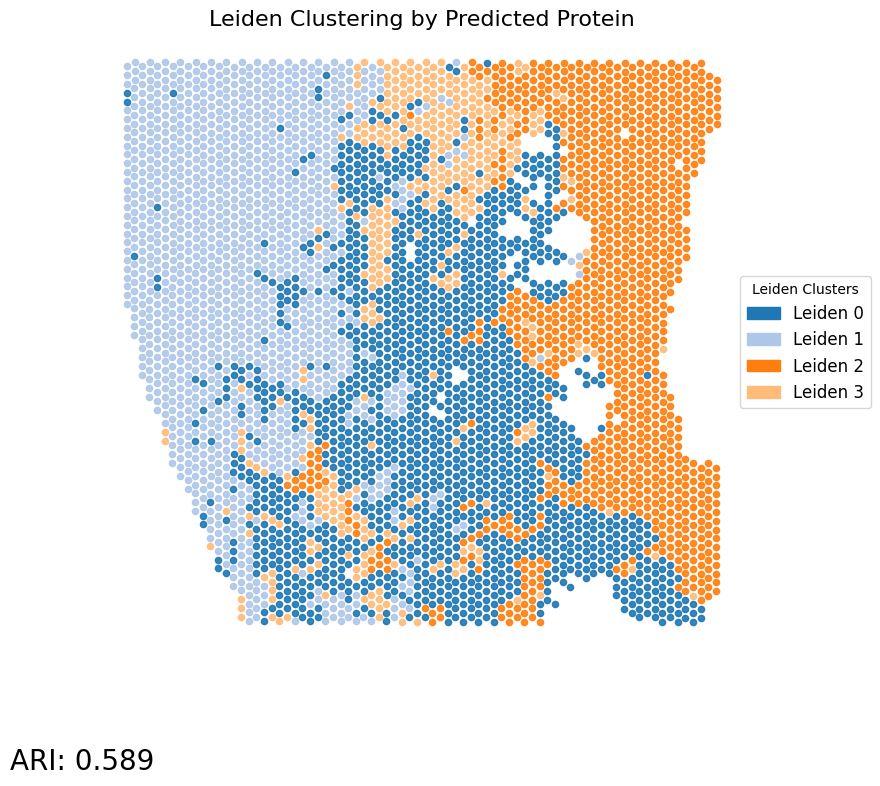

In [21]:
pdata_Prostate = leiden_plot_scatter(pdata_Prostate, n_neighbors=10, size = 20, resolution=0.251, true_label_key = 'annotation', None_anno_cluster = 'Unannotated')

In [22]:
#pdata_Prostate.write(f'{pred_result_path}/Prostate.h5ad')

### iImpact Breast 10X

In [23]:
import pandas as pd
import numpy as np
from anndata import AnnData

cell_info = pd.read_csv('/ix/hosmanbeyoglu/haw309/iImpact_data/human breast cancer FFPE data/10x_human_breast_cancer_ffpe_manual_annotation.csv')
spot_loc = pd.read_csv('/ix/hosmanbeyoglu/haw309/iImpact_data/human breast cancer FFPE data/10x_human_breast_cancer_ffpe_loc.csv', index_col=0)
count     = pd.read_csv('/ix/hosmanbeyoglu/haw309/iImpact_data/human breast cancer FFPE data/10x_human_breast_cancer_ffpe_count.csv', index_col=0)

spot_loc = spot_loc.reset_index().rename(columns={'index': 'spot_id'})
spot_loc['x'] = spot_loc['x'].round(2)
spot_loc['y'] = spot_loc['y'].round(2)

cell_info['x'] = cell_info['x'].round(2)
cell_info['y'] = cell_info['y'].round(2)

merged = pd.merge(cell_info, spot_loc, on=['x', 'y'], how='inner')

adata_iBreast = AnnData(X=count.values)
adata_iBreast.obs_names = count.index.astype(str)
adata_iBreast.var_names = count.columns
adata_iBreast.obsm['spatial'] = spot_loc.set_index('spot_id').loc[count.index].values


coord2class = {
    (round(row['x']), round(row['y'])): row['annotation']
    for _, row in cell_info.iterrows()
}

class_list = []
for x, y in adata_iBreast.obsm["spatial"]:
    key = (round(x), round(y))
    nucleus_class = coord2class.get(key, np.nan) 
    class_list.append(nucleus_class)

adata_iBreast.obs['annotation'] = class_list

adata_iBreast.obs['annotation'] = adata_iBreast.obs['annotation'].fillna('Unannotated')
class_counts = adata_iBreast.obs["annotation"].value_counts()
print(class_counts)

adata_iBreast.uns['name'] = 'Breast_10X'

annotation
Unannotated    1246
tumor           487
fibrous         396
immune          184
necrosis        152
fat              53
Name: count, dtype: int64


In [24]:
adata_iBreast.var_names = [var.split(' ')[0] for var in adata_iBreast.var_names]
adata_iBreast.var_names_make_unique()
preprocess_ST(adata_iBreast)
adata_iBreast = fill_genes(adata_iBreast, common_gene)

Sample lost 393 genes, 11535 in total


In [25]:
pdata_iBreast = protein_predict(adata_iBreast,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'Breast_10X' from '/ix/hosmanbeyoglu/haw309/pyg_data/Breast_10X_11535_spatial=6_testing.pth'
Dataset ready


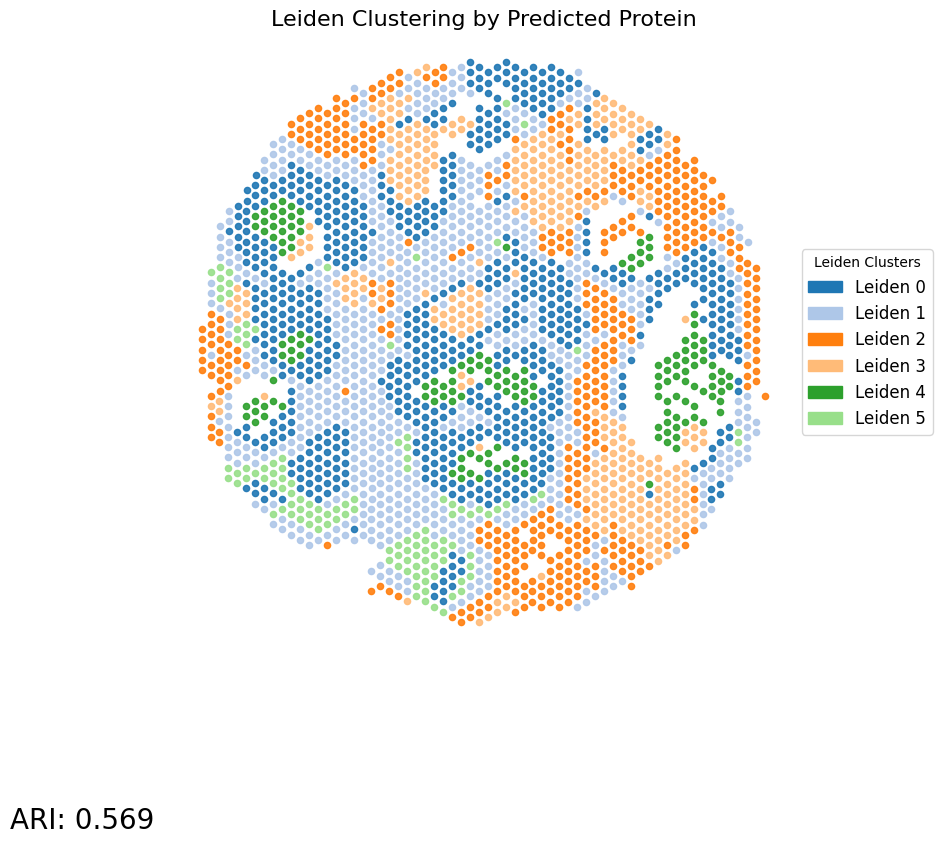

In [26]:
pdata_iBreast = leiden_plot_scatter(pdata_iBreast, n_neighbors=10, size = 20, resolution=0.318, true_label_key = 'annotation', None_anno_cluster = 'Unannotated')

In [27]:
#pdata_iBreast.write(f'{pred_result_path}/iBreast.h5ad')

### Ovarian

In [28]:
import pandas as pd
import numpy as np
from anndata import AnnData

cell_info = pd.read_csv('/ix/hosmanbeyoglu/haw309/iImpact_data/human ovarian cancer FFPE data/10x_human_ovarian_cancer_ffpe_manual_annotation.csv')
spot_loc = pd.read_csv('/ix/hosmanbeyoglu/haw309/iImpact_data/human ovarian cancer FFPE data/10x_human_ovarian_cancer_ffpe_loc.csv', index_col=0)
count     = pd.read_csv('/ix/hosmanbeyoglu/haw309/iImpact_data/human ovarian cancer FFPE data/10x_human_ovarian_cancer_ffpe_count.csv', index_col=0)

spot_loc = spot_loc.reset_index().rename(columns={'index': 'spot_id'})
spot_loc['x'] = spot_loc['x'].round(2)
spot_loc['y'] = spot_loc['y'].round(2)

cell_info['x'] = cell_info['x'].round(2)
cell_info['y'] = cell_info['y'].round(2)

merged = pd.merge(cell_info, spot_loc, on=['x', 'y'], how='inner')


adata_Ovarian = AnnData(X=count.values)
adata_Ovarian.obs_names = count.index.astype(str)
adata_Ovarian.var_names = count.columns
adata_Ovarian.obsm['spatial'] = spot_loc.set_index('spot_id').loc[count.index].values

coord2class = {
    (round(row['x']), round(row['y'])): row['annotation']
    for _, row in cell_info.iterrows()
}

class_list = []
for x, y in adata_Ovarian.obsm["spatial"]:
    key = (round(x), round(y))
    nucleus_class = coord2class.get(key, np.nan)  
    class_list.append(nucleus_class)

adata_Ovarian.obs['annotation'] = class_list

adata_Ovarian.obs['annotation'] = adata_Ovarian.obs['annotation'].fillna('Unannotated')

cluster_mapping = {
        'blue': "Stroma",
        'green': "Tumor",
        "Unannotated":"Unannotated"
    }
adata_Ovarian.obs["annotation"] = adata_Ovarian.obs["annotation"].astype(str).map(cluster_mapping)
class_counts = adata_Ovarian.obs["annotation"].value_counts()
print(class_counts)
adata_Ovarian.uns['name'] = 'Ovarian'

annotation
Unannotated    1512
Tumor          1039
Stroma          904
Name: count, dtype: int64


In [29]:
adata_Ovarian.var_names = [var.split(' ')[0] for var in adata_Ovarian.var_names]
adata_Ovarian.var_names_make_unique()
preprocess_ST(adata_Ovarian)
adata_Ovarian = fill_genes(adata_Ovarian, common_gene)

Sample lost 393 genes, 11535 in total


In [30]:
pdata_Ovarian = protein_predict(adata_Ovarian,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'Ovarian' from '/ix/hosmanbeyoglu/haw309/pyg_data/Ovarian_11535_spatial=6_testing.pth'
Dataset ready


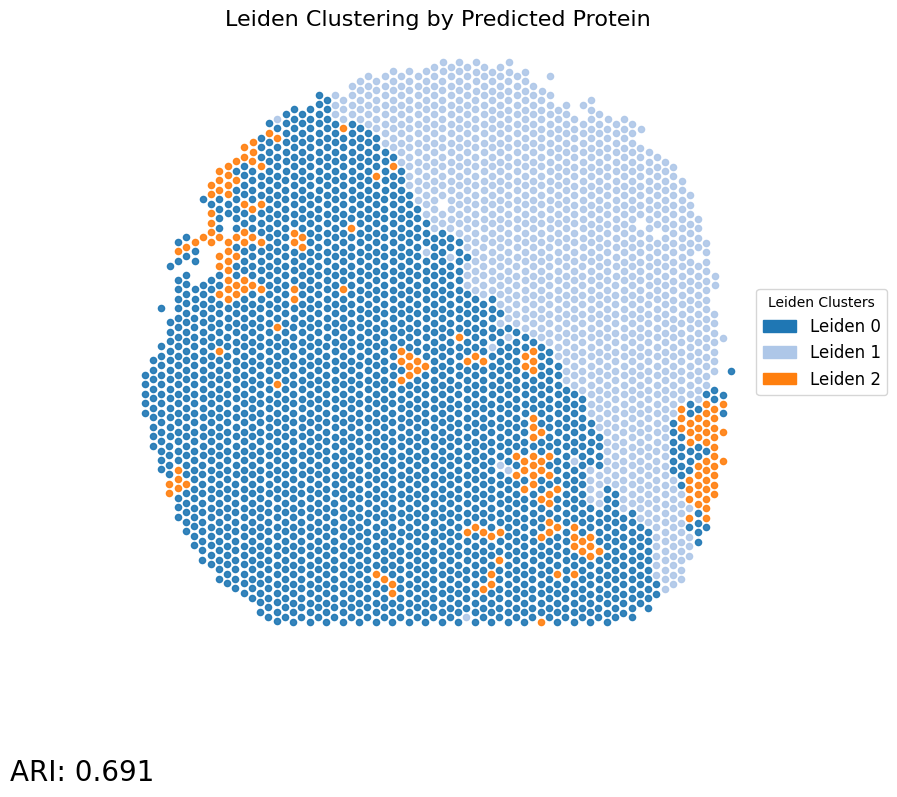

In [31]:
pdata_Ovarian = leiden_plot_scatter(pdata_Ovarian, n_neighbors=10, size = 20, resolution=0.103, true_label_key = 'annotation', None_anno_cluster = 'Unannotated')

In [32]:
#pdata_Ovarian.write(f'{pred_result_path}/iOvarian.h5ad')